In [1]:
#Loading libraries
import json

import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle

import csv

from importlib import reload

import Utilities.Constants as Constants
import Utilities.Functions as Functions

print("Successful!")

Successful!


In [2]:
Params_pyhf = {"Use_flat_sys_bkg":False,
               "Use_flat_sys_signal":True,
               "Stats_only":False,
               "Use_second_half_only":True,
               "Load_logit_hists":True,
               "Use_toys":False,
               "Num_toys":100,
               "Load_lepton_hists":True,
               "Load_pi0_hists":False,
               "Flat_overlay_bkg_frac":0.5,
               "Flat_dirt_bkg_frac":1.0,
               "Flat_sig_KDAR":0.5,
               "Flat_sig_detvar":0.2, #This is very conservative, should be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3,
               "Overlay_detvar_frac":0.5}

Functions.pyhf_params(Params_pyhf)

Using fully evaluated systematic uncertainty for background. Dirt will still be 100%.
Using FLAT systematic uncertainty on signal
With 53.851648071345046% on all signal


In [3]:
#Loading My BDT histograms
# loc_hists = 'bdt_output/'
loc_hists = 'Uncertainties/'

hist_dict_run1 = {}
hist_dict_run3 = {}

#Loading in the .root files
if Params_pyhf["Load_lepton_hists"] == True:
    for HNL_mass in Constants.HNL_mass_samples:
    # for HNL_mass in [10]:
        if Params_pyhf["Load_logit_hists"] == False:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_test2.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_test2.root')
        if Params_pyhf["Load_logit_hists"] == True:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_logit_top_20_merged_NEW.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_logit_top_20_merged_NEW.root')
    
if Params_pyhf["Load_pi0_hists"] == True:
    pi0_dict_run1, pi0_dict_run3 = {}, {}
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        if Params_pyhf["Load_logit_hists"] == False:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_test1.root') #run1_150MeV_logit_test1.root
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_test1.root')
        if Params_pyhf["Load_logit_hists"] == True:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_logit_test1.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_logit_test1.root')

#list_of_dicts = [hist_dict_run1, hist_dict_run3] #Add run2 when available, not using yet

#Constants
theta_squared = Constants.theta_mu_4*Constants.theta_mu_4

print("Success")

Success


In [4]:
overlay_dict, dirt_dict, EXT_dict = {}, {}, {}
signal_dict = {}
bins_dict = {}
bins_cent_dict = {}
tot_uncertainty_dict = {}
xlims = [0,5.0]

Run = "run1"
if Run == "run1":
    hist_dict = hist_dict_run1
elif Run == "run3":
    hist_dict = hist_dict_run3

for HNL_mass in Constants.HNL_mass_samples:
    overlay_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[0]
    dirt_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_dirt'].to_numpy()[0]
    EXT_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_EXT'].to_numpy()[0]
    signal_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].to_numpy()[0]
    
    tot_uncertainty = [hist_dict[HNL_mass]['ppfx_uncertainty'].to_numpy()[0], #overlay ppfx error
                       hist_dict[HNL_mass]['Genie_uncertainty'].to_numpy()[0], #overlay genie error
                       hist_dict[HNL_mass]['Reinteraction_uncertainty'].to_numpy()[0], #overlay reinteraction error
                       hist_dict[HNL_mass]['overlay_DetVar_uncertainty'].to_numpy()[0], #overlay detector variation error
                       hist_dict[HNL_mass]['bkg_dirt'].to_numpy()[0]*Params_pyhf["Flat_dirt_bkg_frac"], #dirt flat systematic error
                       hist_dict[HNL_mass]['bkg_overlay'].errors(), #stat error
                       hist_dict[HNL_mass]['bkg_dirt'].errors(), #stat error
                       hist_dict[HNL_mass]['bkg_EXT'].errors()] #stat error
    
    tot_uncertainty_dict[HNL_mass] = Functions.add_all_errors(tot_uncertainty)
    
    bins_dict[HNL_mass] = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
    bins_cent_dict[HNL_mass]=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2
    
    # maxy_dict[HNL_mass] = max(plt.hist(bins_cent_dict[HNL_mass], weights=overlay_dict[HNL_mass], range = xlims))*1.2
    
bkgs = {'bkg_overlay':overlay_dict, 'bkg_dirt':dirt_dict, 'bkg_EXT':EXT_dict}
print(overlay_dict[HNL_mass])
print(tot_uncertainty_dict[HNL_mass])

[1.3198306e+03 1.0165718e+03 8.1064355e+02 5.8592920e+02 3.5806641e+02
 2.0629980e+02 1.1001367e+02 3.5826172e+01 9.8564453e+00 4.5214844e-01]
[670.7784796  523.34489365 425.65063715 311.55926717 188.8981183
 107.47264728  57.10796562  18.84143351   5.46658936   0.70869986]


In [5]:
def Plot_BDT_output_systematics(signal={}, bkgs={}, bins_cent_dict={}, bins_dict={}, colours={}, ALPHA=1.0, xlims=[0,5.0],figsize=[12,8], density=False, legloc="upper right",
                                logy=False, savefig=False, save_str="", Run="_", HNL_scale=1.0):
    """
    This should take the histograms which have already been binned and scaled and plot the total uncertainties on bkg.
    Therefore it will display what is being fed into the limit setting software.
    """
    
    if(signal=={}): raise Exception("Specify HNL sample masses")
    if(bkgs=={}): raise Exception("Specify background samples")
    if(bins_cent_dict=={}): raise Exception("Specify bin centres")
    if(bins_dict=={}): raise Exception("Specify bins")
    if(colours=={}): colours = {'overlay':Constants.sample_colours['overlay'],
                                'dirtoverlay':Constants.sample_colours['dirtoverlay'],
                                'beamoff':Constants.sample_colours['beamoff'],
                                'signal':Constants.sample_colours['signal']}
    
    if logy == True:
        logscale="log"
    elif logy == False:
        logscale="linear"
    
    for HNL_mass in signal.keys():
        plt.figure(figsize=figsize,facecolor='white')
        
        bins_cents=[bins_cent_dict[HNL_mass], bins_cent_dict[HNL_mass], bins_cent_dict[HNL_mass]]

        bkg_scores=[bkgs['bkg_overlay'][HNL_mass],
                    bkgs['bkg_dirt'][HNL_mass],
                    bkgs['bkg_EXT'][HNL_mass]]
        bkg_colors=[colours['overlay'],colours['dirtoverlay'],colours['beamoff']]
        labels=[fr"In-Cryo $\nu$",fr"Out-Cryo $\nu$",f"Beam-Off"]
        
        hist_placeholder = np.histogram(bins_cents, weights=bkg_scores, range=xlims)[0] #Just for calculating ylims
        
        # maxy = max(hist_placeholder)
        
        hist_full_placeholder = np.histogram(bins_cents, weights=bkg_scores, bins=bins_dict[HNL_mass])[0] #For making the error bars
        numbins = len(np.where( bins_cent_dict[HNL_mass] > xlims[0] )[0])+1 #Getting the number of bins that will be plotted with the given xlims range
               
        plot=plt.hist(bins_cents,
                      label=labels,
                      bins=bins_dict[HNL_mass],
                      histtype="stepfilled",
                      stacked=True,linewidth=2,edgecolor="black",
                      weights=bkg_scores, color=bkg_colors, alpha=ALPHA)
        
        tot_uncrt = tot_uncertainty_dict[HNL_mass]
        upvals_placeholder = hist_full_placeholder+tot_uncrt
        lowvals_placeholder = hist_full_placeholder-tot_uncrt
        upvals = np.append(upvals_placeholder, [0])
        lowvals = np.append(lowvals_placeholder, [0])
        
        maxy = max(upvals[-numbins:])
        
        plt.fill_between(bins_dict[HNL_mass], lowvals, upvals, step="post",color="grey",alpha=0.3,zorder=2)

        plt.hist(bins_cent_dict[HNL_mass],
                 weights=signal[HNL_mass]*HNL_scale,
                 bins=bins_dict[HNL_mass],
                 lw=4, edgecolor=colours['signal'], label=f'HNL {HNL_mass} MeV', histtype="step")
        ylims = [0,maxy*1.1]
        plt.legend(loc=legloc,frameon=True)
        
        plt.xlim(xlims)
        plt.ylim(ylims)
        
        plt.xlabel('BDT score', fontsize=30)
        plt.ylabel('Events', fontsize=30)
        plt.yscale(logscale)
        plt.tight_layout()
        if savefig == True:
            plt.savefig("plots/BDT_output/Final_histograms/" + Run + "_" + str(HNL_mass) + "_MeV_" + logscale + save_str + ".pdf")
            plt.savefig("plots/BDT_output/Final_histograms/" + Run + "_" + str(HNL_mass) + "_MeV_" + logscale + save_str + ".png")
        plt.show()
        

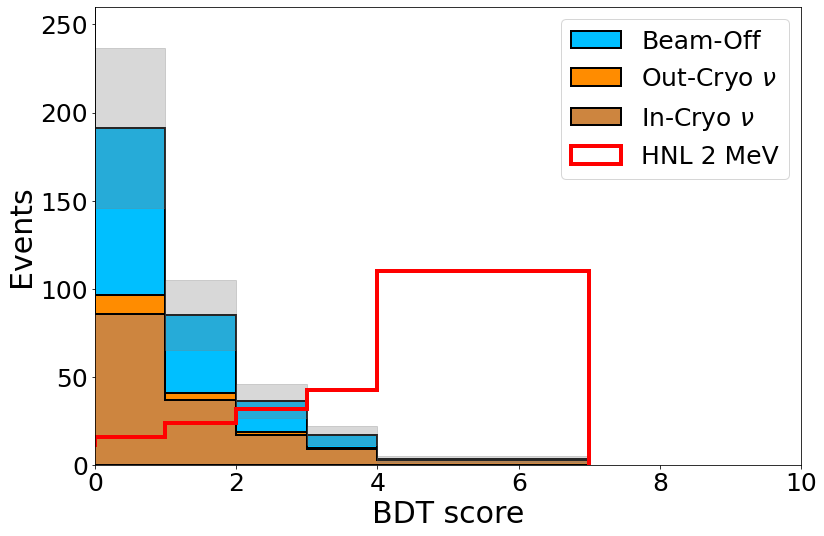

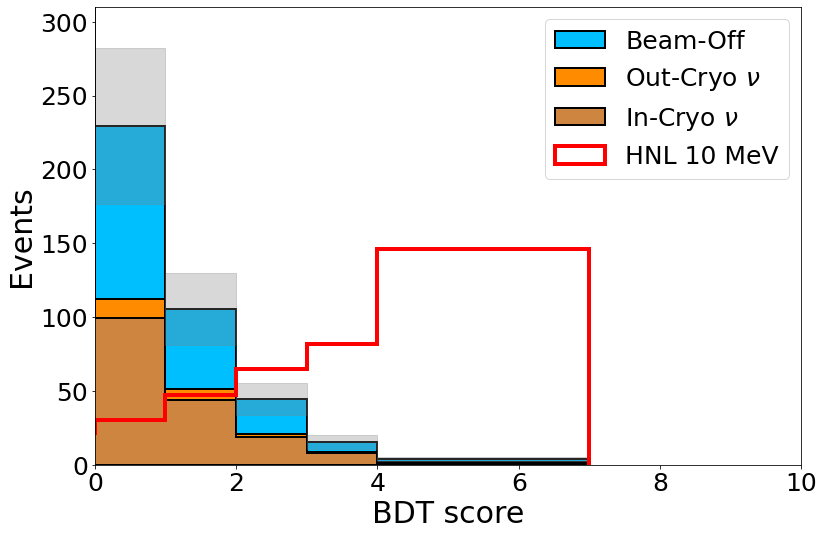

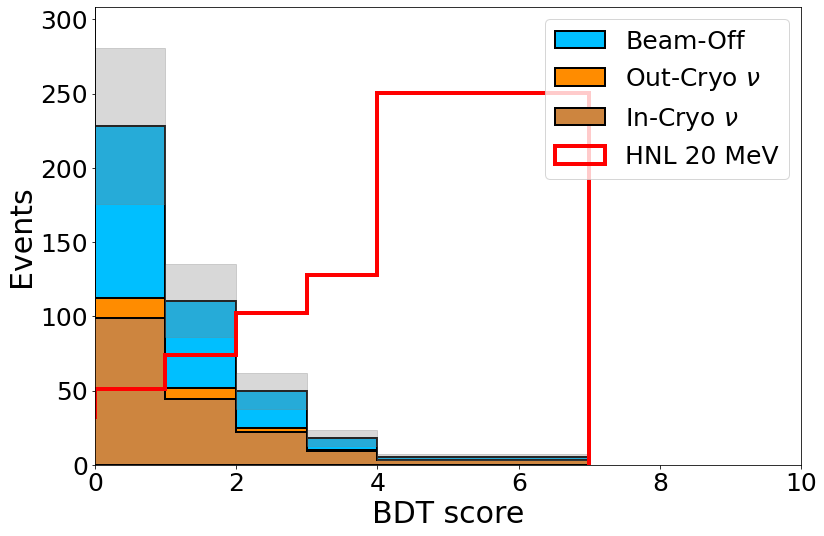

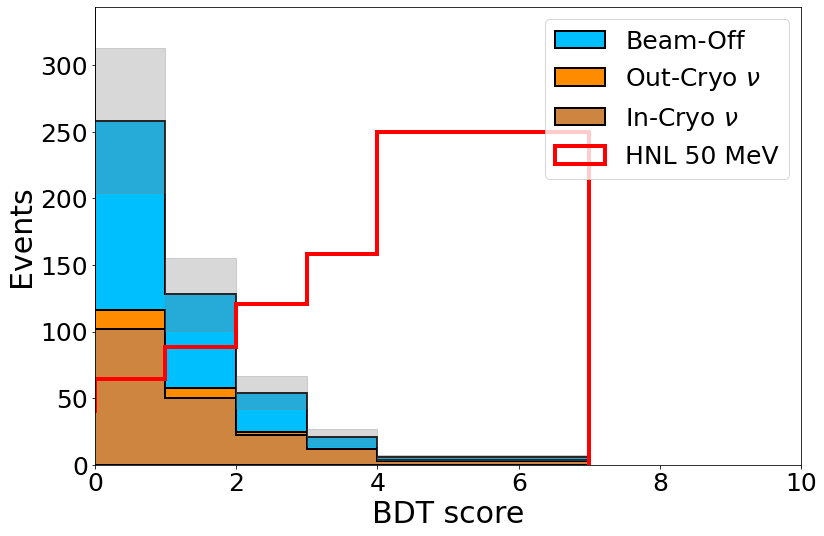

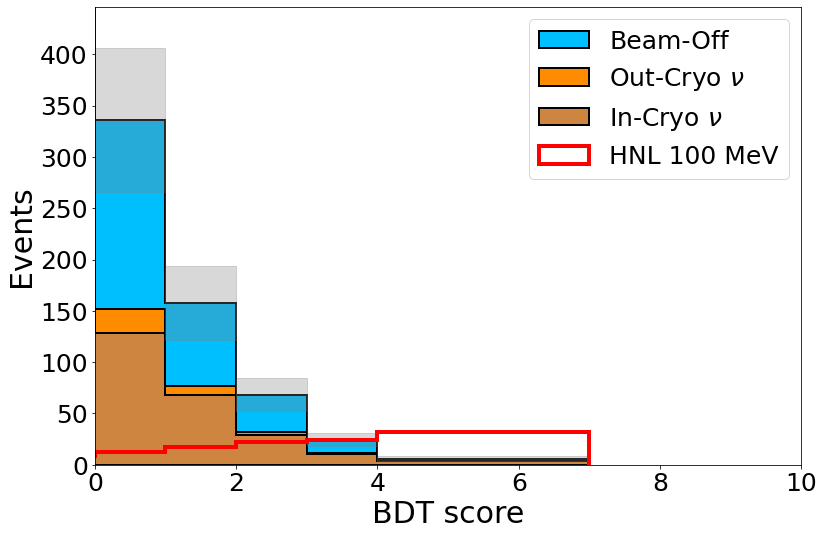

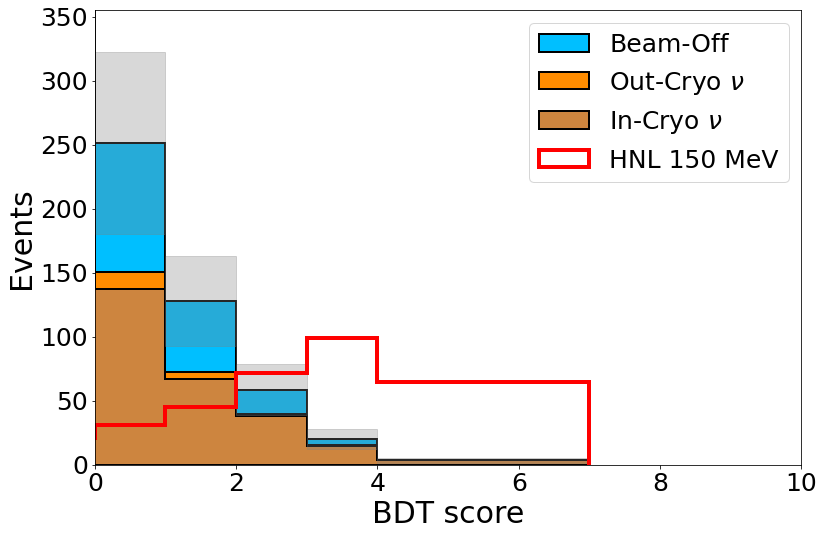

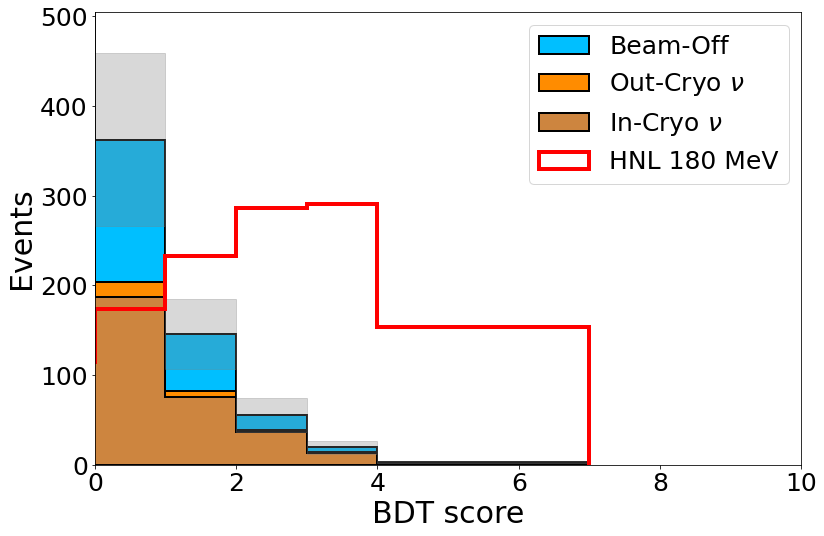

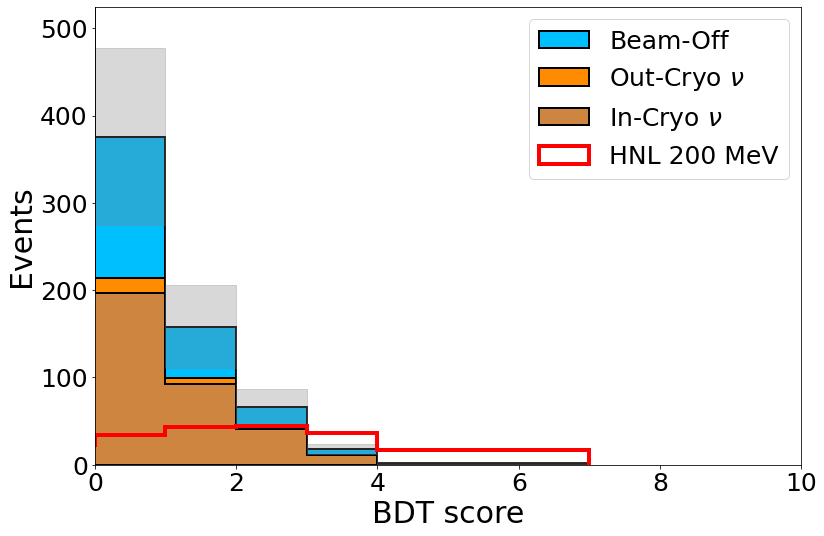

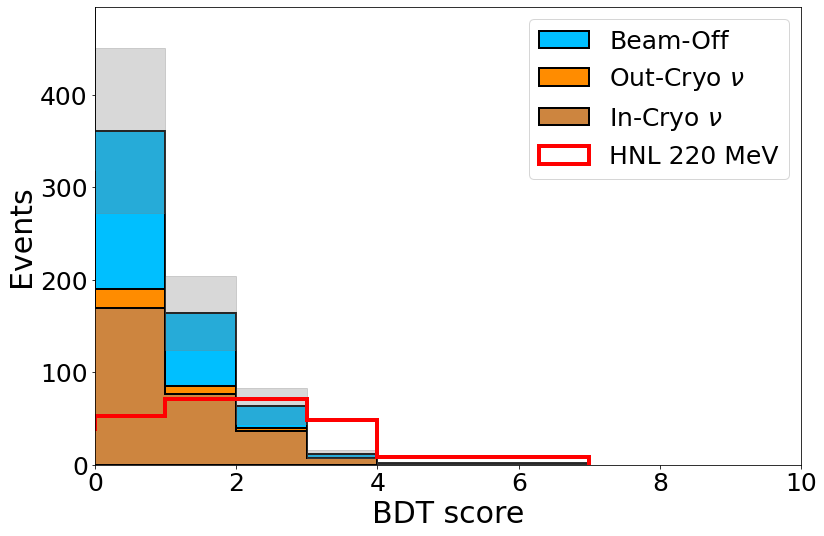

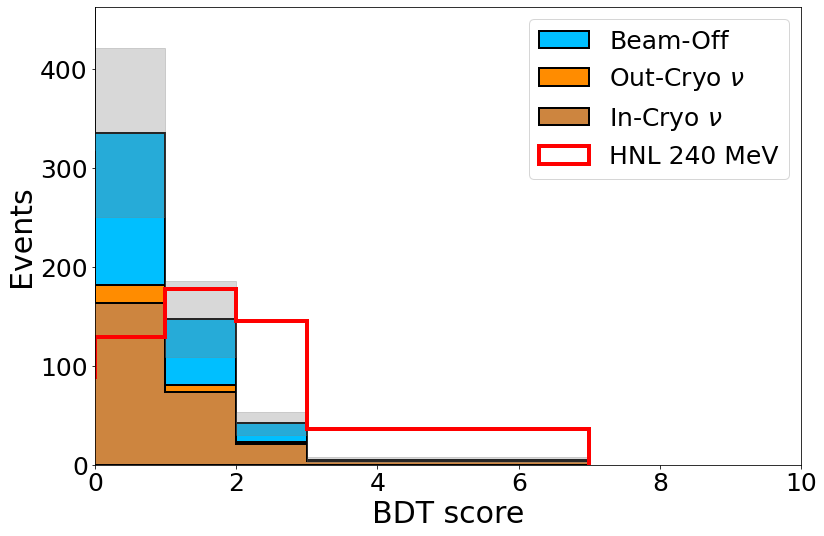

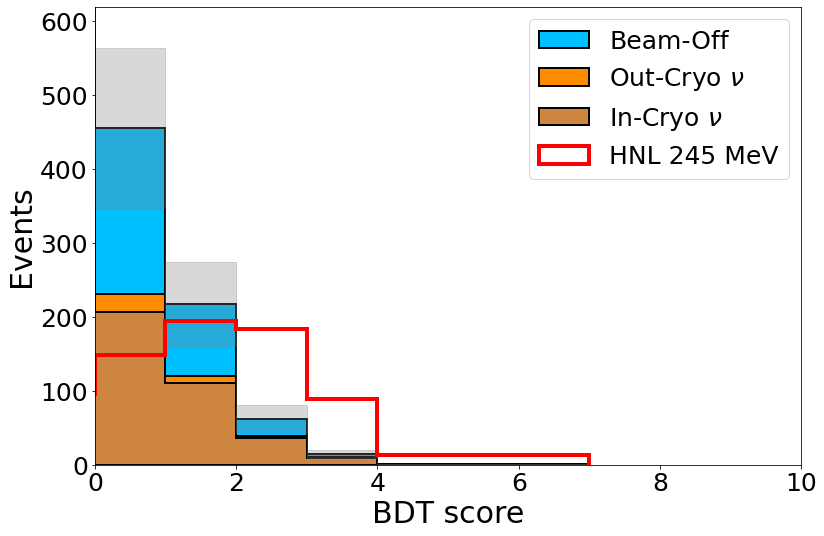

In [6]:
plt.rcParams.update({'font.size': 25})
Plot_BDT_output_systematics(signal_dict, bkgs, bins_cent_dict, bins_dict, xlims=[0,10.0], legloc="upper right",
                                logy=False, savefig=True, save_str="", Run=Run, HNL_scale=5.0)

## Loading in Uncertainties

In [5]:
def Calculate_total_uncertainty(Params, hist_dict, bkg_reweight_err_dict=None, bkg_detvar_dict=None, sig_detvar_dict=None): #Takes the dictionary of all root files
    BKG_ERR_dict, SIGNAL_ERR_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_stat_err_list = [hist_dict[HNL_mass]['bkg_overlay'].errors(), 
                             hist_dict[HNL_mass]['bkg_EXT'].errors(), 
                             hist_dict[HNL_mass]['bkg_dirt'].errors()]
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True:
        #As default the errors saved in the files are stat errors, this will change once I properly calculate them
            bkg_err_list = bkg_stat_err_list
            sig_err = sig_stat_err
        elif Params["Use_flat_sys_bkg"] == True:
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['bkg_overlay'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"] + np.ones_like(hist_dict[HNL_mass]['bkg_overlay'].values())*2.0, #This is horrible need to rewrite 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            else:    
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"], 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        elif Params["Use_flat_sys_bkg"] == False:
            ppfx_unc = hist_dict[HNL_mass]["ppfx_uncertainty"].values()
            genie_unc = hist_dict[HNL_mass]["Genie_uncertainty"].values()
            reint_unc = hist_dict[HNL_mass]["Reinteraction_uncertainty"].values()
            # detvar_unc = bkg_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values() #Don't know what this looks like yet, as I haven't made
            detvar_unc = hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Overlay_detvar_frac"] #Just setting as flat. Too much variation in samples
            tot_overlay_sys = Functions.add_all_errors([ppfx_unc, genie_unc, reint_unc, detvar_unc])
            bkg_sys_err_list = [tot_overlay_sys, 
                                np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]] #Don't have reweight or DetVar samples for dirt
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == True):
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['signal'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} signal last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]+2.0
            else:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == False):
            sig_detvar_err = sig_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_overlay_bkg_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_detvar_err,sig_flux_err]) #Adding stat, detvar and flux errors in quadrature
        total_bkg_err = Functions.add_all_errors(bkg_err_list) #Now adding the errors of overlay, EXT and dirt in quadrature
        BKG_ERR_dict[HNL_mass] = total_bkg_err
        SIGNAL_ERR_dict[HNL_mass] = sig_err
    return BKG_ERR_dict, SIGNAL_ERR_dict
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict


## End of code